In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.contrib.slim as slim
import sys 
    
from lib.envs.simple_rooms import SimpleRoomsEnv
from lib.running_variance import RunningVariance
from lib import plotting
from lib.simulation import Experiment

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class Agent(object):

    def __init__(self, actions):
        self.actions = actions
        self.num_actions = len(actions)

    def act(self, obs):
        raise NotImplementedError

class RandomAgent(Agent):
    
    def __init__(self, actions):
        super(RandomAgent, self).__init__(actions)
    
    def act(self, obs):
        return np.random.randint(0, self.num_actions)

<Figure size 720x360 with 0 Axes>

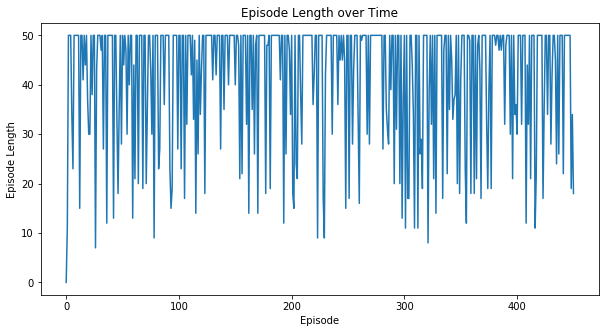

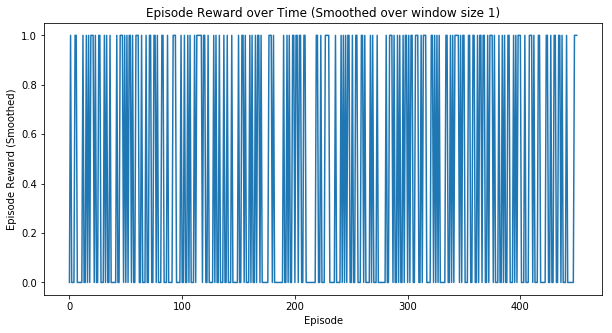

In [3]:
interactive = False
%matplotlib inline    

max_number_of_episodes = 450
env = SimpleRoomsEnv()
agent = RandomAgent(range(env.action_space.n))
experiment = Experiment(env, agent)
experiment.run_agent(max_number_of_episodes, interactive)

In [4]:
np.random.seed(123)

env = SimpleRoomsEnv()

state_dim = len(env.S)
action_count = env.action_space.n 
hidden_size = 128 
update_frequency = 20

In [5]:
class PGAgent():
    def __init__(self, lr):
        self.observations= tf.placeholder(shape=[None,state_dim],dtype=tf.float32)
        hidden = slim.fully_connected(self.observations,hidden_size,biases_initializer=None,activation_fn=tf.nn.relu)
        self.output = slim.fully_connected(hidden,action_count,activation_fn=tf.nn.softmax,biases_initializer=None)
        self.chosen_action = tf.argmax(self.output,1)

        self.return_weight = tf.placeholder(shape=[None],dtype=tf.float32)
        self.action_holder = tf.placeholder(shape=[None],dtype=tf.int32)
        
        self.indexes = tf.range(0, tf.shape(self.output)[0]) * tf.shape(self.output)[1] + self.action_holder
        self.responsible_outputs = tf.gather(tf.reshape(self.output, [-1]), self.indexes)

        self.loss = -tf.reduce_mean(tf.log(self.responsible_outputs)*self.return_weight)
        
        tvars = tf.trainable_variables()
        self.gradient_holders = []
        for idx,var in enumerate(tvars):
            placeholder = tf.placeholder(tf.float32,name=str(idx)+'_holder')
            self.gradient_holders.append(placeholder)
        
        self.gradients = tf.gradients(self.loss,tvars)
        
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        self.update_batch = optimizer.apply_gradients(zip(self.gradient_holders,tvars))

In [6]:
def discount_rewards(r, gamma = 0.999):
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


<IPython.core.display.Javascript object>


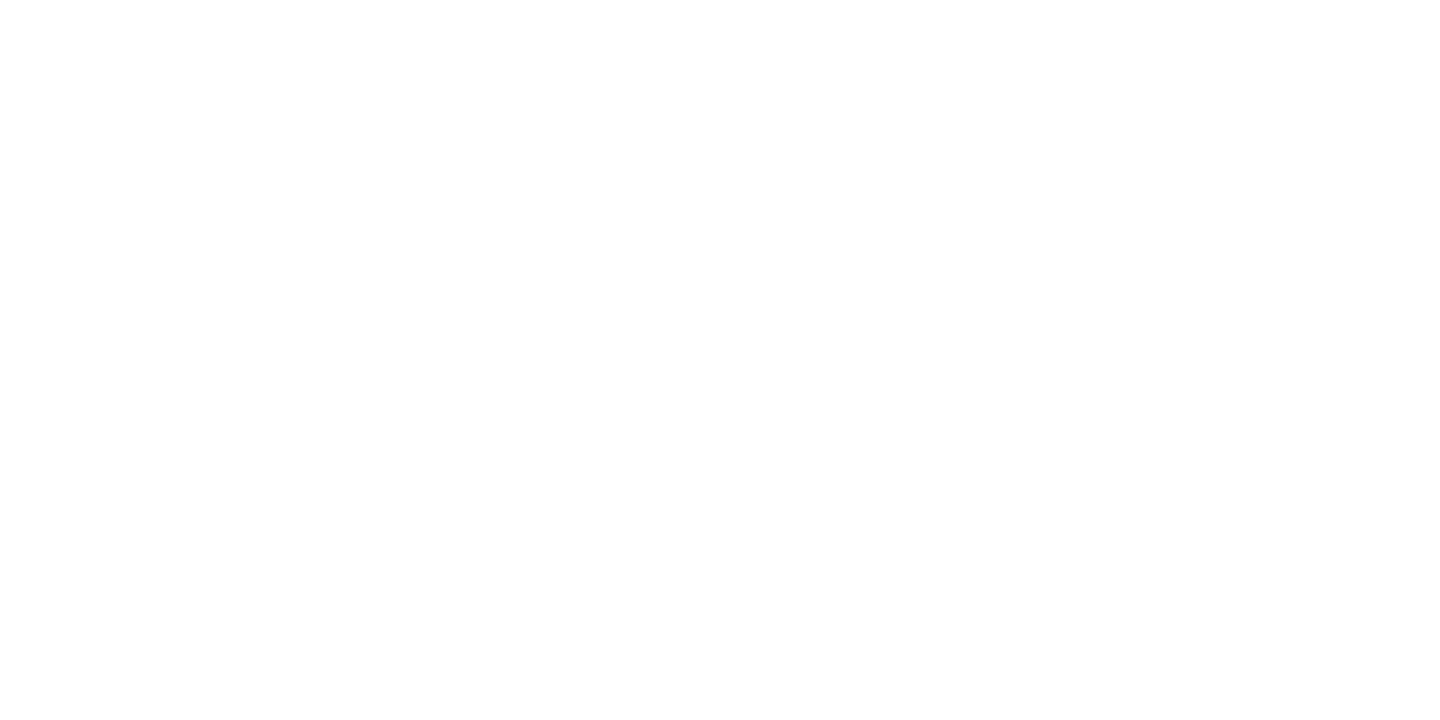

Episode: 20. Average reward for episode 0.650000. Variance 0.243237
Episode: 40. Average reward for episode 0.550000. Variance 0.237903
Episode: 60. Average reward for episode 0.700000. Variance 0.241593
Episode: 80. Average reward for episode 0.950000. Variance 0.240966
Episode: 100. Average reward for episode 0.850000. Variance 0.235736
Episode: 120. Average reward for episode 0.850000. Variance 0.233575
Episode: 140. Average reward for episode 0.950000. Variance 0.226483
Episode: 160. Average reward for episode 1.000000. Variance 0.217575
Episode: 180. Average reward for episode 1.000000. Variance 0.207927
Episode: 200. Average reward for episode 1.000000. Variance 0.199757
Episode: 220. Average reward for episode 1.000000. Variance 0.192177
Episode: 240. Average reward for episode 1.000000. Variance 0.185365
Episode: 260. Average reward for episode 1.000000. Variance 0.178555
Episode: 280. Average reward for episode 1.000000. Variance 0.172800
Episode: 300. Average reward for episo

<IPython.core.display.Javascript object>


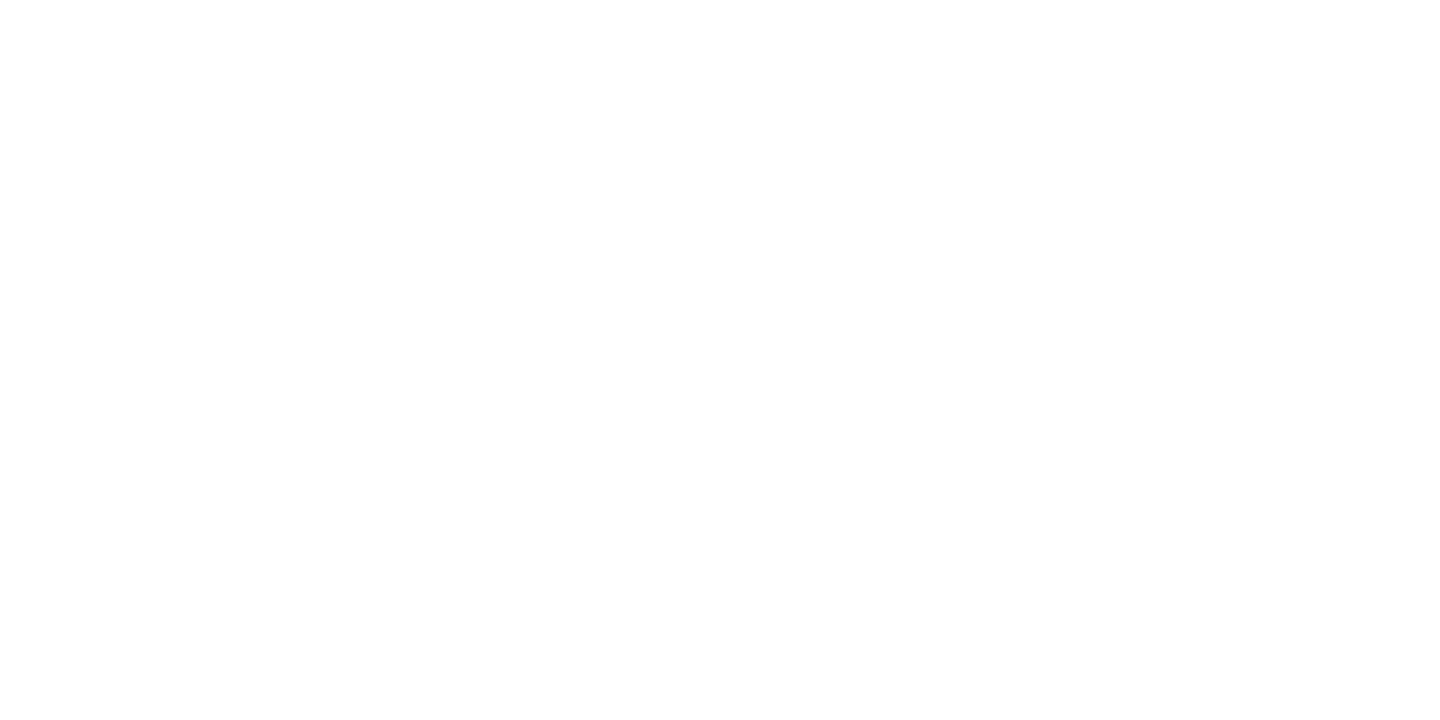

In [7]:
tf.reset_default_graph()

myAgent = PGAgent(lr=1e-2)
%matplotlib nbagg    
experiment = Experiment(env, myAgent)
max_number_of_episodes = 450
running_variance = RunningVariance()
reward_sum = 0

stats = plotting.EpisodeStats(
    episode_lengths=np.zeros(max_number_of_episodes),
    episode_rewards=np.zeros(max_number_of_episodes),
    episode_running_variance=np.zeros(max_number_of_episodes))   

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    total_reward = []
    total_length = []
        
    gradBuffer = sess.run(tf.trainable_variables())
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
        
    for episode_number in range(max_number_of_episodes):
        s = env.reset()
        running_reward = 0
        ep_history = []
        done = False
        t = 1
        while not done:
            
            a_dist = sess.run(myAgent.output,feed_dict={myAgent.observations:[s]})
            a = np.random.choice(a_dist[0],p=a_dist[0])
            a = np.argmax(a_dist == a)
            
            if episode_number > 400:
                env.render()
                experiment.update_display_step()
            
            ns,r,done,_ = env.step(a) 
            ep_history.append([s,a,r,ns])
            s = ns
            
            running_reward += float(r)
                    
            stats.episode_rewards[episode_number] += r
            stats.episode_lengths[episode_number] = t
        
            t += 1

        if episode_number > 400:
            experiment.update_display_episode()

        ep_history = np.array(ep_history)
        ep_history[:,2] = discount_rewards(ep_history[:,2])
        for r in ep_history[:,2]:    
            running_variance.add(r)
       
        feed_dict={myAgent.return_weight:ep_history[:,2],
                   myAgent.action_holder:ep_history[:,1],
                   myAgent.observations:np.vstack(ep_history[:,0])}
        
        grads = sess.run(myAgent.gradients, feed_dict=feed_dict)
        
        for idx,grad in enumerate(grads):
            gradBuffer[idx] += grad

        if episode_number % update_frequency == 0 and episode_number != 0:
            feed_dict = dictionary = dict(zip(myAgent.gradient_holders, gradBuffer))
            _ = sess.run(myAgent.update_batch, feed_dict=feed_dict)
            for ix,grad in enumerate(gradBuffer):
                gradBuffer[ix] = grad * 0
            print('Episode: %d. Average reward for episode %f. Variance %f' % (episode_number, np.mean(total_reward[-update_frequency:]), running_variance.get_variance()))

        total_reward.append(running_reward)
        total_length.append(t)
        experiment.episode_reward = np.append(experiment.episode_reward,running_reward)
        experiment.episode_length = np.append(experiment.episode_length,t)
        
#plotting.plot_pgresults(stats)
